In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage

import torch
from torch import nn, optim

from sklearn.datasets import fetch_openml

In [2]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")

#### Helper Functions

In [5]:
# @title Helper functions


def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)


def init_weights_kaiming_uniform(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming uniform distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming uniform distribution
    nn.init.kaiming_uniform_(layer.weight.data)


def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)


def get_layer_weights(layer):
  """
  Retrieves learnable parameters from PyTorch layer.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    list with learnable parameters
  """
  # initialize output list
  weights = []

  # check whether layer has learnable parameters
  if layer.parameters():
    # copy numpy array representation of each set of learnable parameters
    for item in layer.parameters():
      weights.append(item.detach().numpy())

  return weights


def eval_mse(y_pred, y_true):
  """
  Evaluates mean square error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.MSELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates binary cross-entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
    criterion = nn.BCELoss()
    loss = criterion(y_pred, y_true)

  return float(loss)


def plot_row(images, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]

  for items_idx, items in enumerate(images):

    items = np.array(items)
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
      plt.axis('off')

    plt.tight_layout()


def to_s2(u):
  """
  Projects 3D coordinates to spherical coordinates (theta, phi) surface of
  unit sphere S2.
  theta: [0, pi]
  phi: [-pi, pi]

  Args:
    u (list, numpy array or torch.Tensor of floats)
        3D coordinates

  Returns:
    Spherical coordinates (theta, phi) on surface of unit sphere S2.
  """

  x, y, z = (u[:, 0], u[:, 1], u[:, 2])
  r = np.sqrt(x**2 + y**2 + z**2)
  theta = np.arccos(z / r)
  phi = np.arctan2(x, y)

  return np.array([theta, phi]).T


def to_u3(s):
  """
  Converts from 2D coordinates on surface of unit sphere S2 to 3D coordinates
  (on surface of S2), i.e. (theta, phi) ---> (1, theta, phi).

  Args:
    s (list, numpy array or torch.Tensor of floats)
        2D coordinates on unit sphere S_2

  Returns:
    3D coordinates on surface of unit sphere S_2
  """

  theta, phi = (s[:, 0], s[:, 1])
  x = np.sin(theta) * np.sin(phi)
  y = np.sin(theta) * np.cos(phi)
  z = np.cos(theta)

  return np.array([x, y, z]).T


def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """
  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16, s2=False):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D or 3D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row (integer)
        number of rows in grid

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  if s2:
    x = to_s2(np.array(x))

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0] * n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)

      if s2:
        latent = to_u3(latent)

      with torch.no_grad():
        x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j * image_shape[0]: (j + 1) * image_shape[0],
             i * image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, s2=False, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    fontdict (dictionary)
        style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  if s2:
    x = to_s2(np.array(x))

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)

  if s2:
    if xy_labels is None:
      xy_labels = [r'$\varphi$', r'$\theta$']

    plt.xticks(np.arange(0, np.pi + np.pi / 6, np.pi / 6),
               ['0', '$\\pi/6$', '$\\pi/3$', '$\\pi/2$',
                '$2\\pi/3$', '$5\\pi/6$', '$\\pi$'])
    plt.yticks(np.arange(-np.pi, np.pi + np.pi / 3, np.pi / 3),
               ['$-\\pi$', '$-2\\pi/3$', '$-\\pi/3$', '0',
                '$\\pi/3$', '$2\\pi/3$', '$\\pi$'])

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])


def plot_latent_generative(x, y, decoder_fn, image_shape, s2=False,
                           title=None, xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

    title (string)
        plot title

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, s2=s2, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape, s2=s2)

  plt.tight_layout()
  plt.show()


def plot_latent_ab(x1, x2, y, selected_idx=None,
                   title_a='Before', title_b='After', show_n=500, s2=False):
  """
  Two horizontal subplots with encoder maps.

  Args:
    x1 (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space (left plot)

    x2 (list, numpy array or torch.Tensor of floats)
        digit class of each sample (right plot)

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    selected_idx (list of integers)
        indexes of elements to be plotted

    show_n (integer)
        maximum number of samples in each plot

    s2 (boolean)
        convert 3D coordinates (x, y, z) to spherical coordinates (theta, phi)

  Returns:
    Nothing.
  """

  fontdict = {'weight': 'bold', 'size': 12}

  if len(x1) > show_n:

    if selected_idx is None:
      selected_idx = np.random.choice(len(x1), show_n, replace=False)

    x1 = x1[selected_idx]
    x2 = x2[selected_idx]
    y = y[selected_idx]

  data = np.concatenate([x1, x2])

  if s2:
    xlim, ylim = xy_lim(to_s2(data))

  else:
    xlim, ylim = xy_lim(data)

  plt.figure(figsize=(12, 6))

  ax = plt.subplot(121)
  ax.set_title(title_a, y=1.05)
  plot_latent(x1, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)

  ax = plt.subplot(122)
  ax.set_title(title_b, y=1.05)
  plot_latent(x2, y, fontdict=fontdict, s2=s2)
  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.tight_layout()


def runSGD(net, input_train, input_test, out_train=None, out_test=None,
           optimizer=None, criterion='bce', n_epochs=10, batch_size=32,
           verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN network (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    out_train (torch.Tensor)
        optional target images from train set

    out_test (torch.Tensor)
        optional target images from test set

    optimizer (torch optimizer)
        optional target images from train set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  if out_train is not None and out_test is not None:
    different_output = True
  else:
    different_output = False

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  if optimizer is None:
    optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    if different_output:
      batches_out = torch.split(out_train[shuffle_idx], batch_size)

    for batch_idx, batch in enumerate(batches):

      output_train = net(batch)

      if different_output:
        loss = loss_fn(output_train, batches_out[batch_idx])
      else:
        loss = loss_fn(output_train, batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      if different_output:
        loss_train = loss_fn(output_train, out_train)
      else:
        loss_train = loss_fn(output_train, input_train)

      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      if different_output:
        loss_test = loss_fn(output_test, out_test)
      else:
        loss_test = loss_fn(output_test, input_test)

      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    if different_output:
      loss_mse = f'\nMSE\t {eval_mse(output_train, out_train):0.4f}'
      loss_mse += f'\t\t {eval_mse(output_test, out_test):0.4f}'
    else:
      loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
      loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    if different_output:
      loss_bce = f'BCE\t {eval_bce(output_train, out_train):0.4f}'
      loss_bce += f'\t\t {eval_bce(output_test, out_test):0.4f}'
    else:
      loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
      loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss)/500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()


def image_occlusion(x, image_shape):
  """
  Randomly selects on quadrant of images and sets to zeros.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    image_shape (tuple or list)
        original shape of image

  Returns:
    torch.Tensor.
  """

  selection = np.random.choice(4, len(x))

  my_x = np.array(x).copy()
  my_x = my_x.reshape(-1, image_shape[0], image_shape[1])

  my_x[selection == 0, :int(image_shape[0] / 2), :int(image_shape[1] / 2)] = 0
  my_x[selection == 1, int(image_shape[0] / 2):, :int(image_shape[1] / 2)] = 0
  my_x[selection == 2, :int(image_shape[0] / 2), int(image_shape[1] / 2):] = 0
  my_x[selection == 3, int(image_shape[0] / 2):, int(image_shape[1] / 2):] = 0

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


def image_rotation(x, deg, image_shape):
  """
  Randomly rotates images by +- deg degrees.

  Args:
    x (torch.Tensor of floats)
        vectorized images

    deg (integer)
        rotation range

    image_shape (tuple or list)
        original shape of image

  Returns:
    torch.Tensor.
  """

  my_x = np.array(x).copy()
  my_x = my_x.reshape(-1, image_shape[0], image_shape[1])

  for idx, item in enumerate(my_x):
    my_deg = deg * 2 * np.random.random() - deg
    my_x[idx] = ndimage.rotate(my_x[idx], my_deg,
                               reshape=False, prefilter=False)

  my_x = my_x.reshape(x.shape)

  return torch.from_numpy(my_x)


class AutoencoderClass(nn.Module):
  """
  Deep autoencoder network object (nn.Module) with optional L2 normalization
  of activations in bottleneck layer.

  Args:
    input_size (integer)
        size of input samples

    s2 (boolean)
        whether to L2 normalize activatinos in bottleneck layer

  Returns:
    Autoencoder object inherited from nn.Module class.
  """

  def __init__(self, input_size=784, s2=False):

    super().__init__()

    self.input_size = input_size
    self.s2 = s2

    if s2:
      self.encoding_size = 3

    else:
      self.encoding_size = 2

    self.enc1 = nn.Linear(self.input_size, int(self.input_size / 2))
    self.enc1_f = nn.PReLU()
    self.enc2 = nn.Linear(int(self.input_size / 2), self.encoding_size * 32)
    self.enc2_f = nn.PReLU()
    self.enc3 = nn.Linear(self.encoding_size * 32, self.encoding_size)
    self.enc3_f = nn.PReLU()
    self.dec1 = nn.Linear(self.encoding_size, self.encoding_size * 32)
    self.dec1_f = nn.PReLU()
    self.dec2 = nn.Linear(self.encoding_size * 32, int(self.input_size / 2))
    self.dec2_f = nn.PReLU()
    self.dec3 = nn.Linear(int(self.input_size / 2), self.input_size)
    self.dec3_f = nn.Sigmoid()

  def encoder(self, x):
    """
    Encoder component.
    """
    x = self.enc1_f(self.enc1(x))
    x = self.enc2_f(self.enc2(x))
    x = self.enc3_f(self.enc3(x))

    if self.s2:
        x = nn.functional.normalize(x, p=2, dim=1)

    return x

  def decoder(self, x):
    """
    Decoder component.
    """
    x = self.dec1_f(self.dec1(x))
    x = self.dec2_f(self.dec2(x))
    x = self.dec3_f(self.dec3(x))

    return x

  def forward(self, x):
    """
    Forward pass.
    """
    x = self.encoder(x)
    x = self.decoder(x)

    return x


def save_checkpoint(net, optimizer, filename):
  """
  Saves a PyTorch checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    filename (string)
        filename (without extension)

  Returns:
    Nothing.
  """

  torch.save({'model_state_dict': net.state_dict(),
              'optimizer_state_dict': optimizer.state_dict()},
             filename+'.pt')


def load_checkpoint(url, filename):
  """
  Loads a PyTorch checkpoint from URL is local file not present.

  Args:
    url (string)
        URL location of PyTorch checkpoint

    filename (string)
        filename (without extension)

  Returns:
    PyTorch checkpoint of saved model.
  """

  if not os.path.isfile(filename+'.pt'):
    os.system(f"wget {url}.pt")

  return torch.load(filename+'.pt')


def reset_checkpoint(net, optimizer, checkpoint):
  """
  Resets PyTorch model to checkpoint.

  Args:
    net (torch network)
        ANN network (nn.Module)

    optimizer (torch optimizer)
        optimizer for SGD

    checkpoint (torch checkpoint)
        checkpoint of saved model

  Returns:
    Nothing.
  """

  net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

#### Dataset

In [6]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

test_subset_idx = np.random.choice(len(x_test), 500, replace=False)

print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


#### Pre-trained Model

In [7]:
root = 'https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders'
filename = 'ae_6h_prelu_bce_adam_25e_32b'
url = os.path.join(root, filename)
s2 = True

if s2:
  filename += '_s2'
  url += '_s2'

In [8]:
model = AutoencoderClass(s2=s2)
optimizer = optim.Adam(model.parameters())

encoder = model.encoder
decoder = model.decoder

checkpoint = load_checkpoint(url, filename)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

--2025-09-30 15:07:21--  https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mpbrigham/colaboratory-figures/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt [following]
--2025-09-30 15:07:22--  https://raw.githubusercontent.com/mpbrigham/colaboratory-figures/master/nma/autoencoders/ae_6h_prelu_bce_adam_25e_32b_s2.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8313616 (7.9M) [application/octet-stream]
Saving to: ‘ae_6h_prelu_bce_adam_25e_32b_s2.pt’

     0K .......... .......

/tmp/ipykernel_83437/169132391.py:170: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  items = np.array(items)
/tmp/ipykernel_83437/169132391.py:345: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = to_s2(np.array(x))
/tmp/ipykernel_83437/169132391.py:282: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.

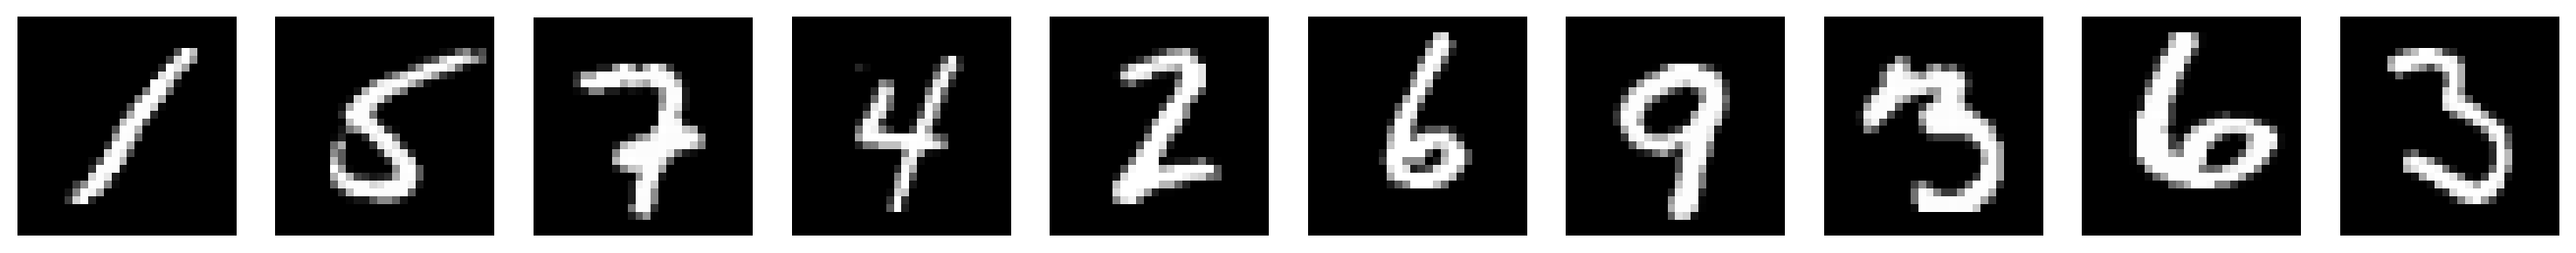

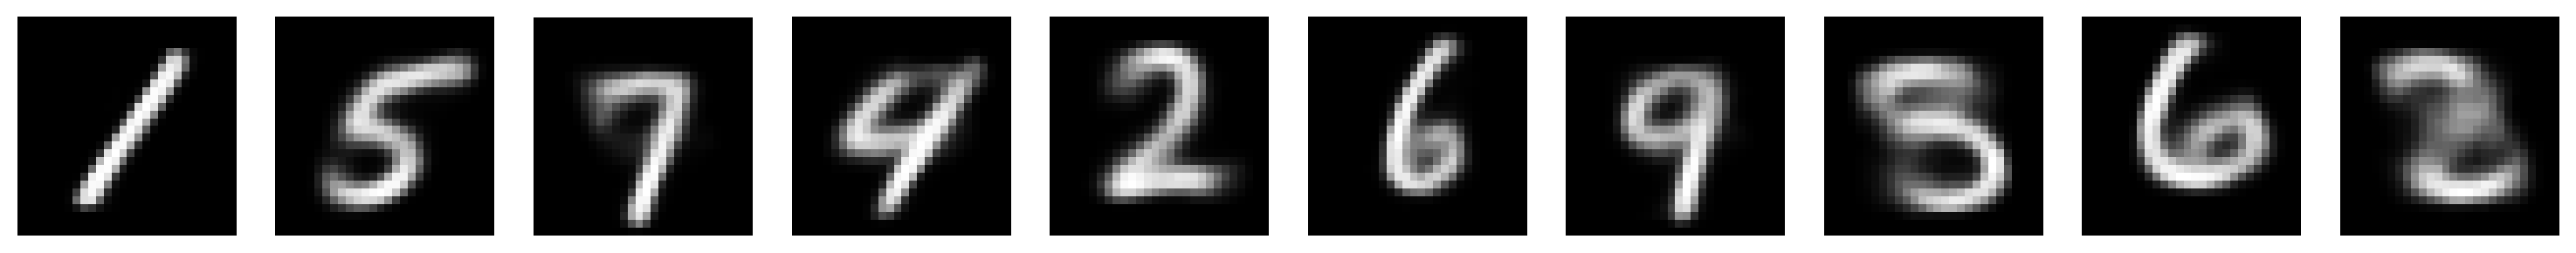

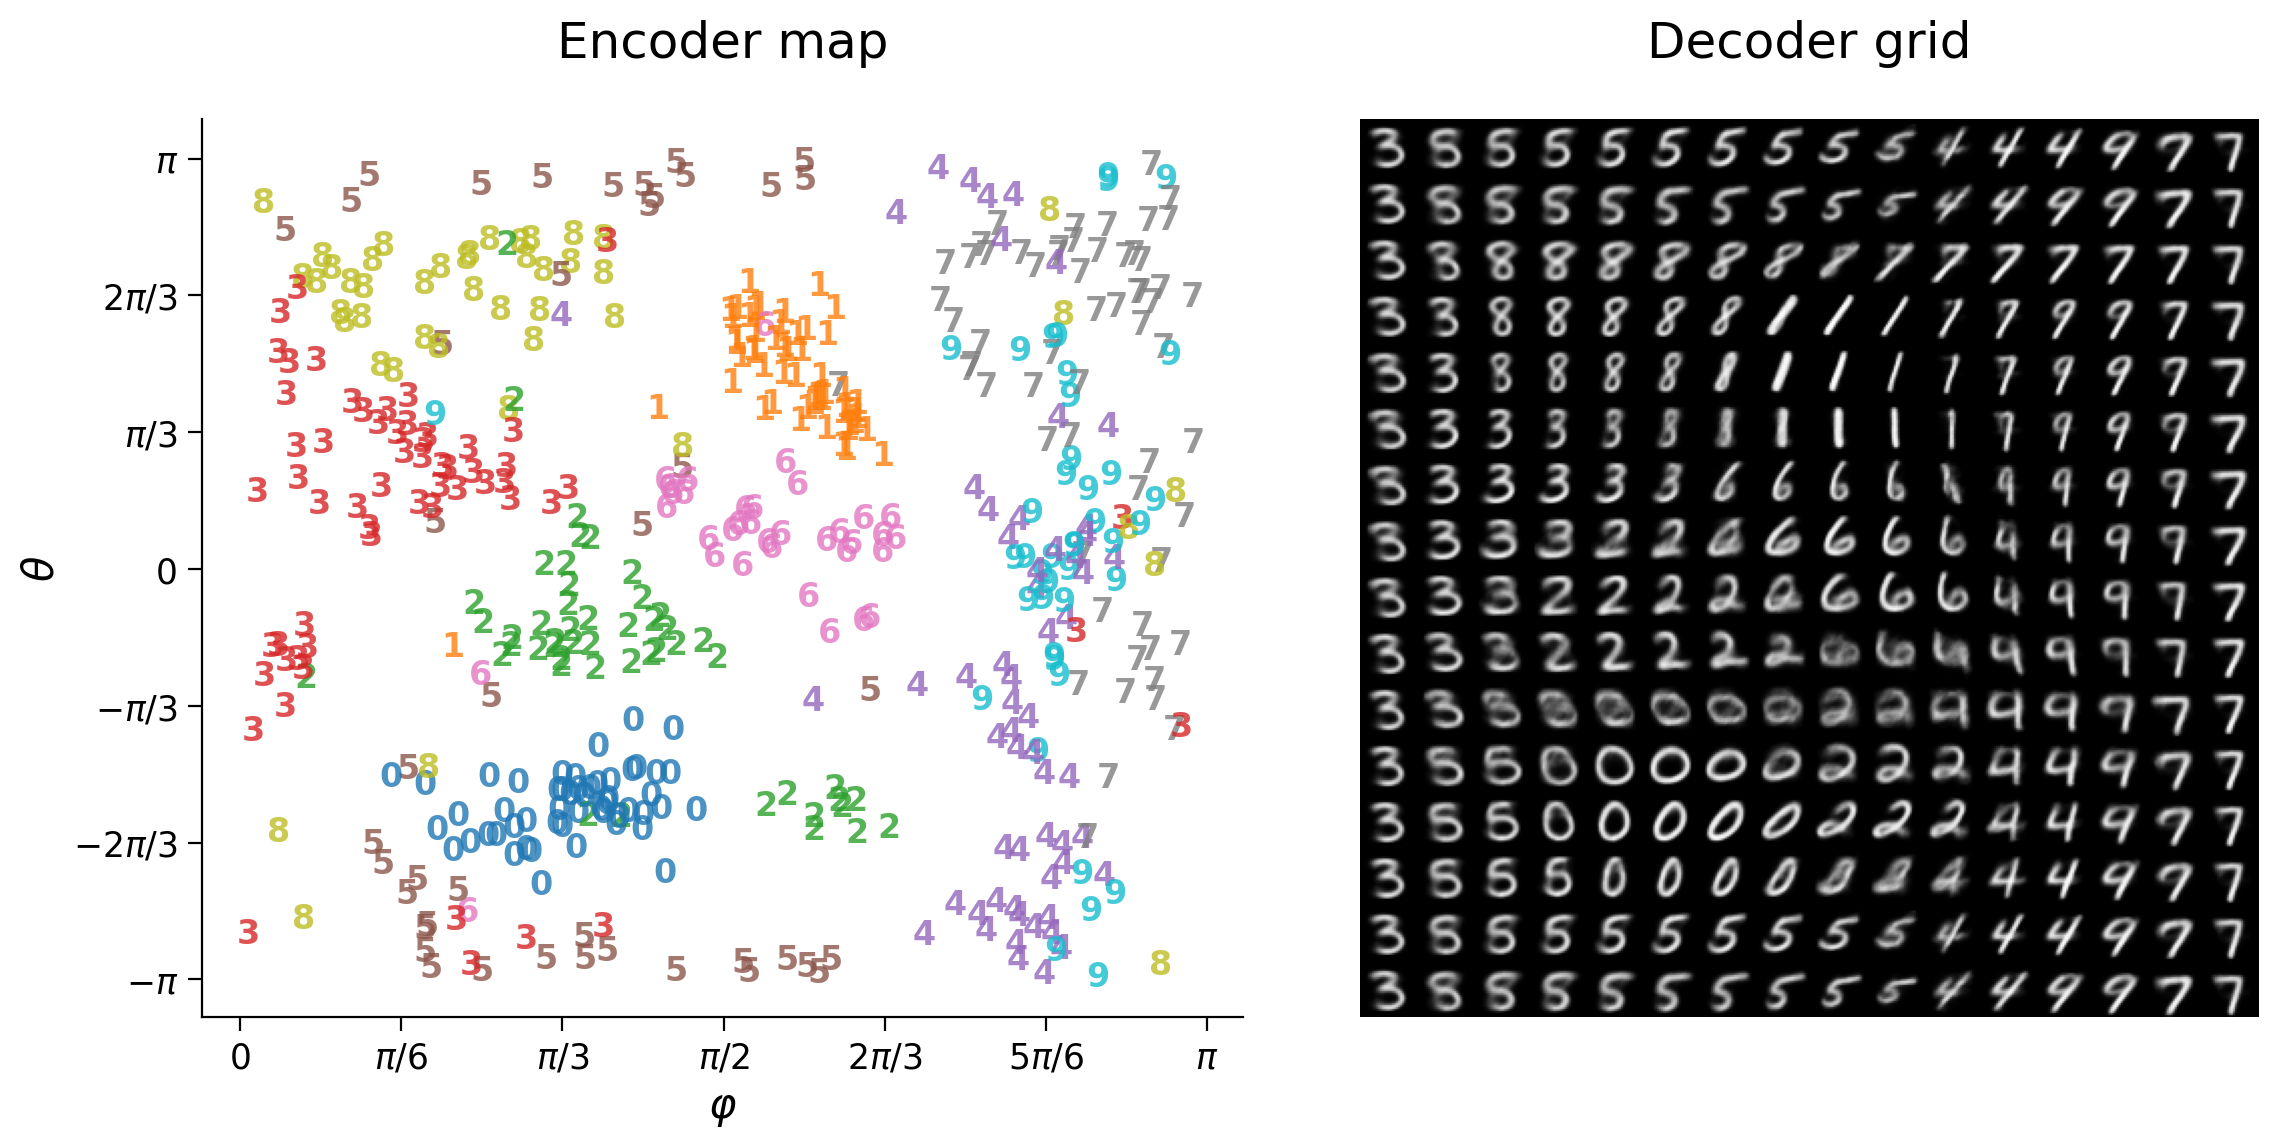

In [9]:
with torch.no_grad():
  output_test = model(input_test)
  latent_test = encoder(input_test)

plot_row([input_test[test_selected_idx], output_test[test_selected_idx]],
         image_shape=image_shape)

plot_latent_generative(latent_test, y_test, decoder,
                       image_shape=image_shape, s2=s2)

#### Image Noise